In [1]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
import config
from tqdm import tqdm
from utils import to_grayscale

gen = Generator(in_channels=3, inter_images=4, out_channels=3)
checkpoint = torch.load("model/gen_LSM_v2.pth.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

torch.Size([5, 128, 100, 100])


In [2]:
image = np.array(Image.open("image_dataset/landslide/Test/3114.jpg"))

def generated_lsm_mask(gen, image_seq, inter_images_num=4):
    inter_image_dict = {}
    input_image = image_seq[:, :config.IMAGE_SIZE, :]
    for idx in range(inter_images_num):
        start_idx = config.IMAGE_SIZE * (idx + 1)
        end_idx = config.IMAGE_SIZE * (idx + 2)
        inter_image_dict[idx] = image_seq[:, start_idx:end_idx, :]

    target_image = image_seq[:, config.IMAGE_SIZE * (inter_images_num + 1):, :]

    for idx, inter_image in enumerate(inter_image_dict.values()):
        inter_image_dict[idx] = config.transform_only_input(image=inter_image)["image"]

    target_image = config.transform_only_mask_binarize(image=target_image)["image"]
    input_image = config.transform_only_input(image=input_image)["image"]

    generated_output = gen(input_image.unsqueeze(0), z1=inter_image_dict[0].unsqueeze(0), 
                              z2=inter_image_dict[1].unsqueeze(0), 
                              z3=inter_image_dict[2].unsqueeze(0), 
                              z4=inter_image_dict[3].unsqueeze(0))
    # return generated_output
    return (generated_output[0].permute(1,2,0).detach().numpy() > 0.5) * 1., (target_image.permute(1,2,0).detach().numpy() > 0.5) * 1.

In [5]:
image = np.array(Image.open("image_dataset/landslide-self/Test/Subeda Landslide Buries Jeep.jpg"))
generated = generated_lsm_mask(gen=gen, image_seq=image, inter_images_num=4)

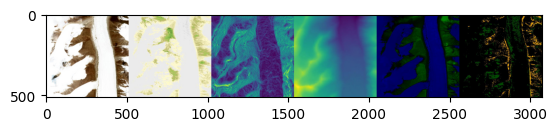

In [6]:
plt.imshow(image)

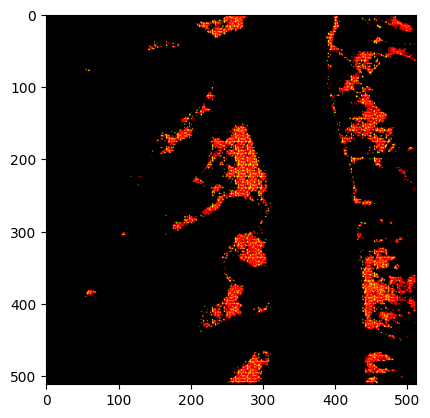

In [7]:
plt.imshow(generated[0])